 * Serving Flask app '__main__'
 * Debug mode: off
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Output: 1


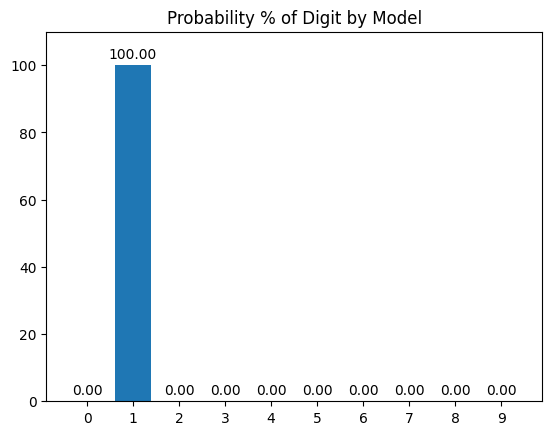

In [2]:
import os
import uuid
import numpy as np
from flask import Flask, request, jsonify, render_template
import tensorflow as tf
from PIL import Image
from flask_cors import CORS
from jinja2 import TemplateNotFound 
import base64
import matplotlib.pyplot as plt
from io import BytesIO
import logging
from logging.handlers import RotatingFileHandler

# Path to the public folder
base_path = r'./temp/'

# Initialize Flask application
app = Flask(__name__, static_folder="static")
cors = CORS(app, origins=["http://localhost:3000"])

# Configure logging
logging.basicConfig(filename=r'./public/app.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
file_handler = RotatingFileHandler('app.log', maxBytes=1024 * 1024, backupCount=5)
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
app.logger.addHandler(file_handler)

# Load the TensorFlow model
model_path = r"best_model.keras"
model = tf.keras.models.load_model(model_path)

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def prob_img(probs):
    fig, ax = plt.subplots()
    rects = ax.bar(range(len(probs)), probs)
    ax.set_xticks(range(len(probs)), labels=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
    ax.set_ylim(0, 110)
    ax.set_title('Probability % of Digit by Model')
    autolabel(rects, ax)
    probimg = BytesIO()
    fig.savefig(probimg, format='png')
    probencoded = base64.b64encode(probimg.getvalue()).decode('utf-8')
    return probencoded

@app.route('/process', methods=['POST'])

def upload_file():
    try:
        # Get the base64 encoded image data from the POST request
        data = request.form['file']
        # Decode the base64 image data
        image_data = base64.b64decode(data.split(',')[1])
        
        # Generate a UUID identifier
        c_uuid = str(uuid.uuid4())

        # Construct the file path
        filename = os.path.join(base_path, c_uuid + '.png')

        # Save the image data to a file
        with open(filename, 'wb') as f:
            f.write(image_data)

        # Load the image and convert to grayscale
        img = Image.open(filename).convert("L")

        # Resize the image
        new_image = img.resize((28, 28))

        # Convert image to array and resize
        x = np.array(new_image).reshape((28, 28, 1))
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])

        # Predict the digit in the image
        classes = model.predict(images, batch_size=1)

        # Get the predicted digit (class)
        result = int(np.argmax(classes))
        print("Output:", result)
        # Close the image
        img.close()

        # Remove the uploaded image
        os.remove(filename)

        # Return the result as JSON
        return jsonify({'value': result,
                        'prob': prob_img(classes[0]*100)}
                        )

    except Exception as e:
        print("Error:", str(e))
        return jsonify({'error': str(e)}), 500

# Endpoint for digit recognition from uploaded image
@app.route('/', methods=['GET', 'POST'])
def start():
    try:
        return render_template(r'default.html')
    except TemplateNotFound:
        return "Template not found!", 404
    except Exception as e:
        print("Error:", str(e))
        return "Error: {}".format(e), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
